In [1]:
# This notebook is to try out simple statistical models for time-series data

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
%matplotlib inline

In [2]:
# date
numdays = 365*10 + 2
base = '2010-01-01'
base = datetime.strptime(base, '%Y-%m-%d')
date_list = [base + timedelta(days=x) for x in range(numdays)]
date_list = np.array(date_list)
print(len(date_list), date_list[0], date_list[-1])

# temp
x = np.linspace(-np.pi, np.pi, 365)
temp_year = (np.sin(x) + 1.0) * 15
x = np.linspace(-np.pi, np.pi, 366)
temp_leap_year = (np.sin(x) + 1.0)
temp_s = []
for i in range(2010, 2020):
    if i == 2010:
        temp_s = temp_year + np.random.rand(365) * 20
    elif i in [2012, 2016]:
        temp_s = np.concatenate((temp_s, temp_leap_year * 15 + np.random.rand(366) * 20 + i % 2010))
    else:
        temp_s = np.concatenate((temp_s, temp_year + np.random.rand(365) * 20 + i % 2010))
print(len(temp_s))

# df
data = np.concatenate((date_list.reshape(-1, 1), temp_s.reshape(-1, 1)), axis=1)
df_orig = pd.DataFrame(data, columns=['date', 'temp'])
df_orig['date'] =  pd.to_datetime(df_orig['date'], format='%Y-%m-%d')
df = df_orig.set_index('date')
df.sort_index(inplace=True)
df

3652 2010-01-01 00:00:00 2019-12-31 00:00:00
3652


,temp
date,
2010-01-01,34.194108
2010-01-02,20.023728
2010-01-03,23.437568
2010-01-04,20.422557
2010-01-05,15.460188
...,...
2019-12-27,44.092534
2019-12-28,42.964866
2019-12-29,36.285981


Text(0, 0.5, 'temperature')

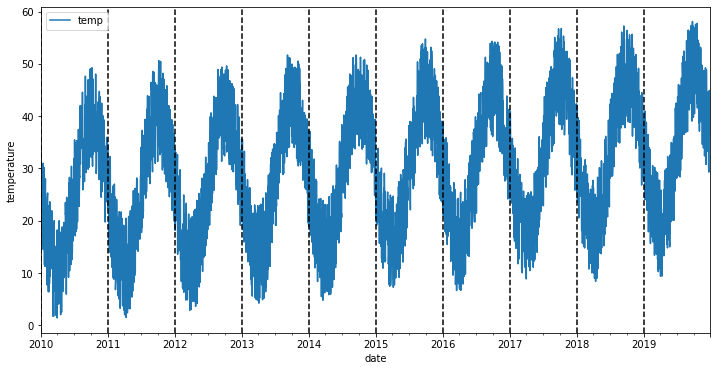

In [3]:
ax = df_orig.plot(x='date', y='temp', figsize=(12,6))
xcoords = ['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
           '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
ax.set_ylabel('temperature')

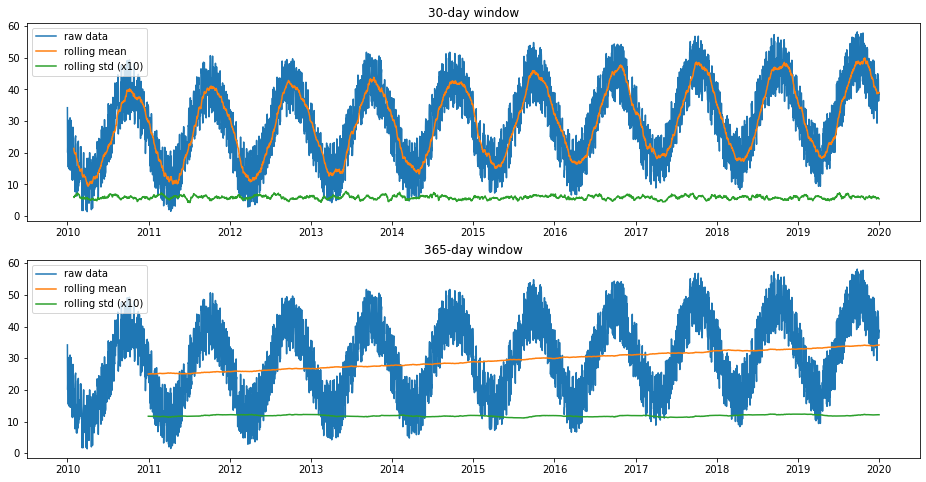

In [4]:
def analyze_stationarity(timeseries, title):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))

    rolmean = pd.Series(timeseries).rolling(window=30).mean() 
    rolstd = pd.Series(timeseries).rolling(window=30).std()
    ax[0].plot(timeseries, label= title)
    ax[0].plot(rolmean, label='rolling mean');
    ax[0].plot(rolstd, label='rolling std (x10)');
    ax[0].set_title('30-day window')
    ax[0].legend()
    
    rolmean = pd.Series(timeseries).rolling(window=365).mean() 
    rolstd = pd.Series(timeseries).rolling(window=365).std()
    ax[1].plot(timeseries, label= title)
    ax[1].plot(rolmean, label='rolling mean');
    ax[1].plot(rolstd, label='rolling std (x10)');
    ax[1].set_title('365-day window')
    ax[1].legend()
    
pd.options.display.float_format = '{:.8f}'.format
analyze_stationarity(df['temp'], 'raw data')


In [5]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

ADF_test(df)

Results of Dickey-Fuller Test:
Test Statistic                  -3.60786165
p-value                          0.00561250
Lags Used                       30.00000000
Number of Observations Used   3621.00000000
Critical Value (1%)             -3.43215722
Critical Value (5%)             -2.86233853
Critical Value (10%)            -2.56719507
dtype: float64


In [6]:
def KPSS_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries.dropna(), regression="c", nlags="auto")    
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

KPSS_test(df)

Results of KPSS Test:
Test Statistic           1.13936409
p-value                  0.01000000
Lags Used               37.00000000
Critical Value (10%)     0.34700000
Critical Value (5%)      0.46300000
Critical Value (2.5%)    0.57400000
Critical Value (1%)      0.73900000
dtype: float64


C:\Users\adity\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                  -3.40616323
p-value                          0.01075055
Lags Used                       29.00000000
Number of Observations Used   3258.00000000
Critical Value (1%)             -3.43235874
Critical Value (5%)             -2.86242754
Critical Value (10%)            -2.56724246
dtype: float64


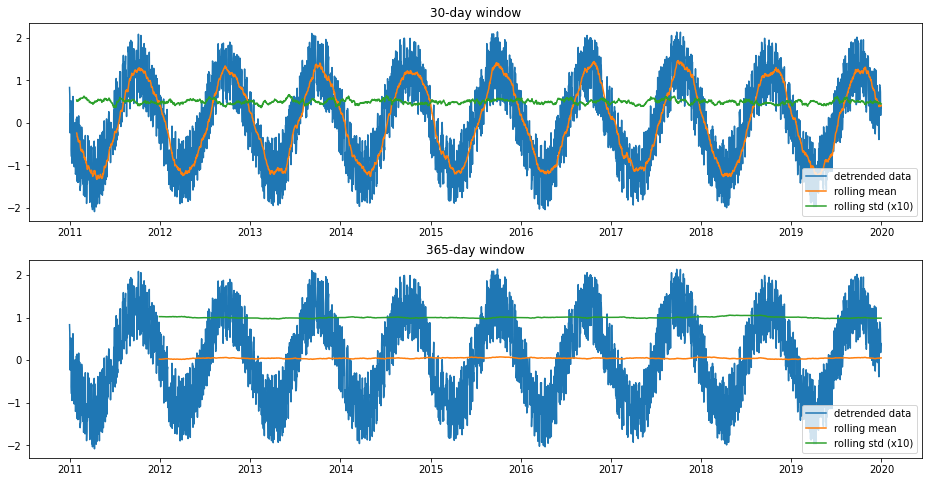

In [7]:
df_detrend = (df - df.rolling(window=365).mean()) / df.rolling(window=365).std()

analyze_stationarity(df_detrend['temp'].dropna(), 'detrended data')
ADF_test(df_detrend.dropna())

Results of Dickey-Fuller Test:
Test Statistic                 -58.54577865
p-value                          0.00000000
Lags Used                        0.00000000
Number of Observations Used   3286.00000000
Critical Value (1%)             -3.43234161
Critical Value (5%)             -2.86241997
Critical Value (10%)            -2.56723843
dtype: float64


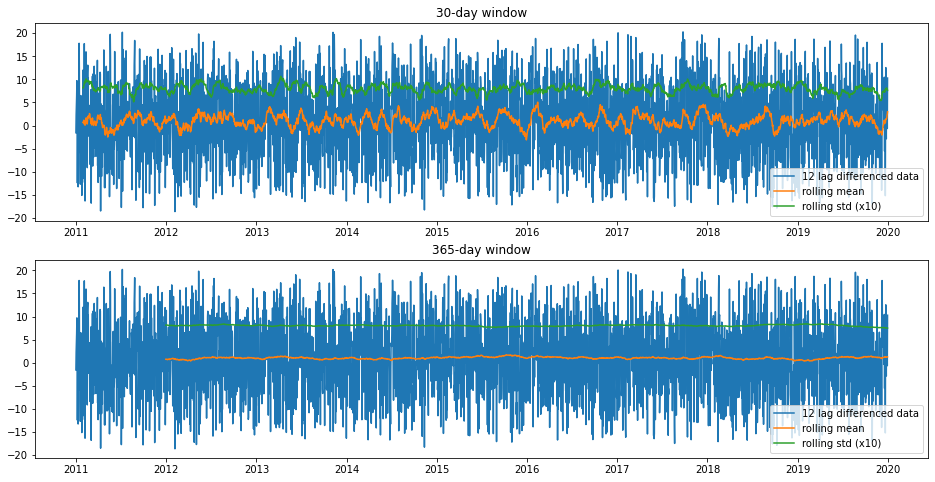

In [8]:
df_365lag =  df - df.shift(365)

analyze_stationarity(df_365lag['temp'].dropna(), '12 lag differenced data')
ADF_test(df_365lag.dropna())

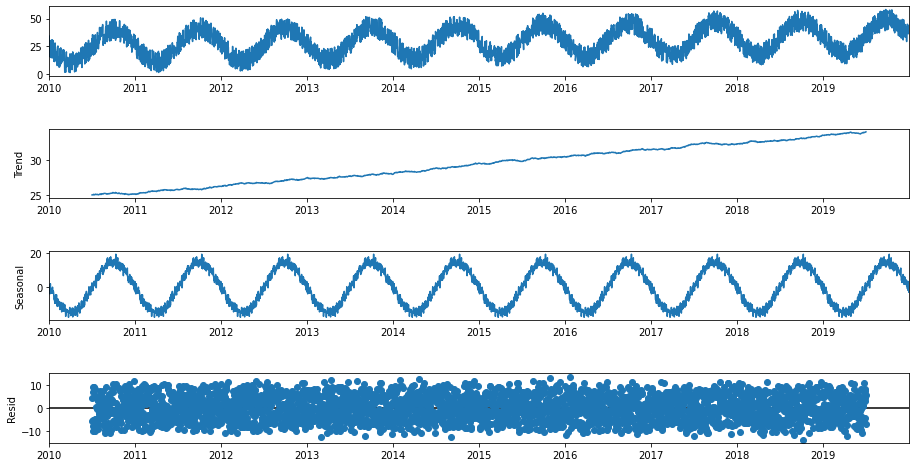

(date
 2010-01-01   NaN
 2010-01-02   NaN
 2010-01-03   NaN
 2010-01-04   NaN
 2010-01-05   NaN
               ..
 2019-12-27   NaN
 2019-12-28   NaN
 2019-12-29   NaN
 2019-12-30   NaN
 2019-12-31   NaN
 Name: trend, Length: 3652, dtype: float64,
 date
 2010-01-01    0.12449554
 2010-01-02   -2.84715752
 2010-01-03   -1.16214869
 2010-01-04   -3.83126197
 2010-01-05    0.06877040
                  ...    
 2019-12-27   -1.67824171
 2019-12-28    0.20346116
 2019-12-29    3.41820747
 2019-12-30    0.12449554
 2019-12-31   -2.84715752
 Name: seasonal, Length: 3652, dtype: float64,
 date
 2010-01-01   NaN
 2010-01-02   NaN
 2010-01-03   NaN
 2010-01-04   NaN
 2010-01-05   NaN
               ..
 2019-12-27   NaN
 2019-12-28   NaN
 2019-12-29   NaN
 2019-12-30   NaN
 2019-12-31   NaN
 Name: resid, Length: 3652, dtype: float64)

In [9]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=365)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual
   
seasonal_decompose(df)